# Import Libraries

In [3]:
# data analysis and wrangling
import pandas as pd 
import numpy as np 

# visualization
import matplotlib.pyplot as plt 

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import clone 

#metrics
from sklearn.model_selection import cross_val_score #k fold cv
from sklearn.metrics import mean_absolute_error, r2_score

# model creation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

#feature importance
from xgboost import XGBClassifier

# Libraries for R^2 visualization
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin

# Libraries for Linear Model building
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression


# Data Wrangling and Exploration

In [5]:
#Create function to import data
def wrangle(path):
    df = pd.read_csv(path)

    #drop null colomns
    df.drop('Unnamed: 0', axis = 1, inplace = True) 

    #drop high null count features
    df.drop(columns = ['Rotten Tomatoes', 'Age'], inplace = True)

    #drop high cardinality features
    high_card_cols = ['Title', 'Directors', 'ID', 'Type']
    df.drop(columns = high_card_cols, inplace = True)

    #drop_cols = []
    return df

In [6]:
# Create dataframe using wrangle function
df = wrangle('MoviesOnStreamingPlatforms_updated.csv')

pd.set_option('display.max_columns', 100)

In [8]:
# df.select_dtypes(include='object').describe()

In [9]:
# df.select_dtypes('object').nunique()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         16744 non-null  int64  
 1   IMDb         16173 non-null  float64
 2   Netflix      16744 non-null  int64  
 3   Hulu         16744 non-null  int64  
 4   Prime Video  16744 non-null  int64  
 5   Disney+      16744 non-null  int64  
 6   Genres       16469 non-null  object 
 7   Country      16309 non-null  object 
 8   Language     16145 non-null  object 
 9   Runtime      16152 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.3+ MB


In [11]:
df.head()

,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Genres,Country,Language,Runtime
0,2010,8.8,1,0,0,0,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1999,8.7,1,0,0,0,"Action,Sci-Fi",United States,English,136.0
2,2018,8.5,1,0,0,0,"Action,Adventure,Sci-Fi",United States,English,149.0
3,1985,8.5,1,0,0,0,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,1966,8.8,1,0,1,0,Western,"Italy,Spain,West Germany",Italian,161.0


In [12]:
df['Netflix'].value_counts()

0    13184
1     3560
Name: Netflix, dtype: int64

# Categorical Observation Clean-up

- Features 'Language', 'Genre', 'Country' have some observations with multiple values (e.g. Country could contain observation of 'Mexico,South Korea,Colombia')
- Goal is to convert observation to binary values of each country (e.g. 'Mexico,South Korea,Colombia' would add 1 to a Mexico feature, South Korea feature, Columbia feature)

### Language Expanding

In [13]:
def col_lang(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult languages
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Language_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Language_', '')
    
    #concat the Language feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Language' col with na values with string copy so it can be iterable
    df_final['Language'] = df_final['Language'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Language'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Language'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_lang so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Language')
    df_orig.drop(columns = 'Language', inplace = True)

    return df_orig

### Country Expanding

In [14]:
def col_country(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult coutries
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Country_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Country_', '')
    
    #concat the Country feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Country' col with na values with string copy so it can be iterable
    df_final['Country'] = df_final['Country'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Country'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Country'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_final so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Country')
    df_orig.drop(columns = 'Country', inplace = True)

    return df_orig

### Genres Expanding

In [15]:
def col_genres(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult genres
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Genres_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Genres_', '')
    
    #concat the Genres feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Genres' col with na values with string copy so it can be iterable
    df_final['Genres'] = df_final['Genres'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Genres'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Genres'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_final so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Genres')
    df_orig.drop(columns = 'Genres', inplace = True)

    return df_orig

In [16]:
#Expand language, country, and genres column in original dataframe for modeling
df = col_lang(df[['Language']], df[['Language']], df)
df = col_country(df[['Country']], df[['Country']], df)
df = col_genres(df[['Genres']], df[['Genres']], df)

In [17]:
df.head()

,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,Afrikaans,Akan,Albanian,Arabic,Assamese,Azerbaijani,Basque,Bengali,Bhojpuri,Bosnian,Brazilian Sign Language,Bulgarian,Cantonese,Catalan,Chinese,Croatian,Czech,Danish,Dari,Dutch,English,Estonian,Filipino,Finnish,French,Georgian,German,Greek,Gujarati,Hebrew,Hindi,Hungarian,Icelandic,Indonesian,Italian,Japanese,Kannada,Kinyarwanda,Kirghiz,Korean,Latin,Latvian,Macedonian,...,Russia,Saudi Arabia,Serbia,Singapore,South Africa,South Korea,Soviet Union,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Trinidad and Tobago,Turkey,U.S. Virgin Islands,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,West Germany,Yugoslavia,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,2010,8.8,1,0,0,0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1999,8.7,1,0,0,0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,8.5,1,0,0,0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,8.5,1,0,0,0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1966,8.8,1,0,1,0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
#Drop na values
df.dropna(inplace = True)
df.shape

(15532, 204)

In [20]:
# Comment to remember code
# 'English' in df_lang['Language'].values[0]
    

In [21]:
# Comment to remember how code works for iterable

# for i, value in enumerate(df_lang['Language'].values):
#     print(i)
#     print(value)
#     print(type(value))

# Target creation and Splitting Data

Look into what factors could determine if a show gets on to Netflix

In [22]:
#Create target variable, set without target, and set with only target
target = 'IMDb'
X = df.drop(columns = target)
y = df[target]

In [23]:
assert len(X) == len(y)

### Split into train, test, val data

Will split randomly. Won't split by year since I would rather have that as a feature

In [24]:
# Use train-split function to divide train, validation, test with a (0.6, 0.2, 0.2 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Doing 0.25 x 0.8 = 0.2 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

In [25]:
assert len(X_train + X_test + X_val == len(X))
assert len(y_train + y_test + y_val == len(y))

In [26]:
X_train.isnull().sum()

Year           0
Netflix        0
Hulu           0
Prime Video    0
Disney+        0
              ..
Sport          0
Talk-Show      0
Thriller       0
War            0
Western        0
Length: 203, dtype: int64

In [27]:
y_train.isnull().sum()

0

# Create Model

### Model based on results of randomized search and grid search

In [28]:
# Ridge Regression Model
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(strategy = 'mean'),
                      StandardScaler(),
                      Ridge(alpha = 600),
                      )
                                             
model.fit(X_train, y_train)

C:\Users\Eric\.virtualenvs\DS-Unit-2-Applied-Modeling-OVqDOShY\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=600))])

### Used for creating randomized search and Grid Search models

In [30]:
# Model for Randomized Search and Grid Search
# cf = make_pipeline(OneHotEncoder(use_cat_names=True),
#                    SimpleImputer(strategy = 'mean'),
#                    StandardScaler(),
#                    Ridge()
#                    )

# param grid for Randomized Search and Grid Search
# param_grid = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'ridge__alpha': np.linspace(100,2000, 20)
# }


In [31]:
# dir(cf.named_steps['ridge'])

### Randomized Search

In [32]:
# # Randomized search for ridge regression

# model_r = RandomizedSearchCV(
#     cf,
#     param_distributions=param_grid,
#     n_iter=60,
#     cv=None,
#     n_jobs=-1,
#     verbose = 1
# )

# model_r.fit(X_train, y_train)

In [33]:
# model_r.best_params_

# SelectKBest

In [34]:
# SelectKBest Model based on randomized search
model_skb = make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(strategy = 'mean'),
                      StandardScaler(),
                      SelectKBest (k=100),
                      Ridge(alpha = 400),
                      )
                                             
model_skb.fit(X_train, y_train)

C:\Users\Eric\.virtualenvs\DS-Unit-2-Applied-Modeling-OVqDOShY\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Eric\.virtualenvs\DS-Unit-2-Applied-Modeling-OVqDOShY\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 27 130 137 139 166 168] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Eric\.virtualenvs\DS-Unit-2-Applied-Modeling-OVqDOShY\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=100)),
                ('ridge', Ridge(alpha=400))])

In [35]:
# # Model for Randomized Search and Grid Search
# cf_rs = make_pipeline(OneHotEncoder(use_cat_names=True),
#                    SimpleImputer(strategy = 'mean'),
#                    StandardScaler(),
#                    SelectKBest(),
#                    Ridge()
#                    )

# # param grid for Randomized Search and Grid Search
# param_grid_rs = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'selectkbest__k': range(50, 150, 10),
#     'ridge__alpha': range(200,500,50)
# }


In [36]:
# model_skb_rs = RandomizedSearchCV(
#     cf_rs,
#     param_distributions=param_grid_rs,
#     n_iter=60,
#     cv=None,
#     n_jobs=-1,
#     verbose = 1
# )

# model_skb_rs.fit(X_train, y_train)

In [37]:
# model_skb_rs.best_params_

In [38]:
# dir(model_skb.named_steps['selectkbest'])

In [39]:
# np.linspace(0,0.001, 10)

# Check Metrics

### Establish Baseline

In [40]:
#Baseline accuracy
y_pred = [y_train.mean()] * len(y_train)
print('Mean Rating:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean Rating: 5.8871324318523275
Baseline MAE: 1.0718829218141974


### Check accuracy scores for train, val, and test set

In [41]:
# MAE for Ridge Model
print('R = 600 training MAE:', mean_absolute_error(y_train, model.predict(X_train))) 
print('R = 600 val MAE:', mean_absolute_error(y_val, model.predict(X_val)))
print('R = 600 test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
print()
print('R = 100, k = training MAE:', mean_absolute_error(y_train, model_skb.predict(X_train))) 
print('R = 100, k = val MAE:', mean_absolute_error(y_val, model_skb.predict(X_val)))
print('R = 100, k = test MAE:', mean_absolute_error(y_test, model_skb.predict(X_test)))

R = 600 training MAE: 0.8387793888549367
R = 600 val MAE: 0.8556280154063589
R = 600 test MAE: 0.8742918878410503

R = 100, k = training MAE: 0.8433035575673999
R = 100, k = val MAE: 0.8550030248422102
R = 100, k = test MAE: 0.8734664001811949


In [42]:
# R2 Score for Ridge Model

print('R = 600 training R2:', r2_score(y_train, model.predict(X_train))) 
print('R = 600 val R2:', r2_score(y_val, model.predict(X_val)))
print('R = 600 test R2:', r2_score(y_test, model.predict(X_test)))
print()
print('R = 100, k = 400 training R2:', r2_score(y_train, model_skb.predict(X_train))) 
print('R = 100, k = 400 val R2:', r2_score(y_val, model_skb.predict(X_val)))
print('R = 100, k = 400 test R2:', r2_score(y_test, model_skb.predict(X_test)))


R = 600 training R2: 0.351460189013479
R = 600 val R2: 0.3310045173351499
R = 600 test R2: 0.3196422638655171

R = 100, k = 400 training R2: 0.34482900697062413
R = 100, k = 400 val R2: 0.3340194179030742
R = 100, k = 400 test R2: 0.31972058501484557


# Feature Importance

### Get Top 10 Features

In [43]:
# dir(model.named_steps['onehotencoder])

In [44]:
# Grab features and coefficients from ridge model
coefficients = model['ridge'].coef_
features = model['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

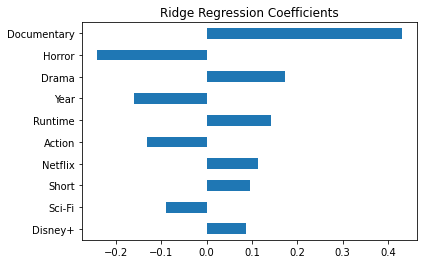

In [45]:
#Looks better. graph below shows why longitude matters
feat_imp.tail(10).plot(kind='barh')
plt.title('Ridge Regression Coefficients')
plt.show()